# **iHeart DNN**

In [ ]:
#@title Install
!pip install wfdb > /dev/null 2>&1;

In [ ]:
#@title **Import**
import wfdb
from wfdb import io, plot
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import glob
from scipy.io import loadmat
from keras.utils import to_categorical
import seaborn as sns
from sklearn.utils import resample
from collections import Counter
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten
from keras.models import Sequential
import pickle
from sklearn.metrics import confusion_matrix as cm
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#@title **Mount Drive**
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Data**

In [ ]:
records = np.load('/content/drive/MyDrive/HeartDisease/PHYSIONET_DATA/all_data.npy', allow_pickle=1)
y = np.load('/content/drive/MyDrive/HeartDisease/PHYSIONET_DATA/y.npy')
labels = np.load('/content/drive/MyDrive/HeartDisease/PHYSIONET_DATA/labels.npy')

labels

array(['Bundle branch block', 'Cardiomyopathy', 'Dysrhythmia',
       'Healthy control', 'Heart failure (NYHA 2)',
       'Heart failure (NYHA 3)', 'Heart failure (NYHA 4)', 'Hypertrophy',
       'Myocardial infarction', 'Myocarditis', 'Palpitation',
       'Stable angina', 'Unstable angina', 'Valvular heart disease',
       'n/a'], dtype='<U22')

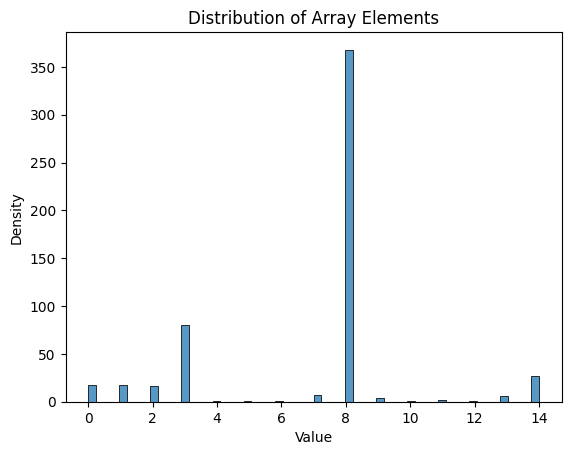

In [ ]:
# Plot the KDE
sns.histplot(y)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of Array Elements')
plt.show()

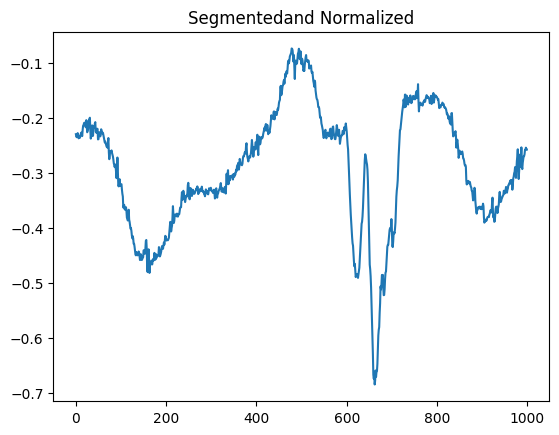

In [ ]:
signal = records[0][:1000]
plt.plot(signal)
plt.title('Segmentedand Normalized')
plt.show()

In [ ]:

all_label = list(y)
all_data = list(records)


"""Discrete Wavelet Transform"""

import pywt
from statsmodels.robust import mad

#DISCRETE WAVELET TRANSFORM
mf = ['sym8']

hasil = []
for i in range(len(all_data)):
    data = []
    for j in range(len(mf)):
        w=pywt.Wavelet(mf[j])
        ca=[]
        cd=[]
        levels=8
        l = all_data[i]

        for level in range(levels):
            (l, h)=pywt.dwt(l, w)
            ca.append(l)
            cd.append(h)

        l = [0]*len(l)
        l=np.array(l)
        cd.append(l)

        tho = mad(cd[0])
        uthr = tho*np.sqrt(2*np.log(len(all_data[i])))

        new_cd = []
        for h in cd :
            new_cd.append(pywt.threshold(h, value=uthr, mode='soft')) #soft thresolding

        cd_rec = new_cd.copy()
        new_cd.reverse()
        new_signal = pywt.waverec(new_cd, w)
        data.append(new_signal)
        x = np.asarray(data)
        x= x.transpose()
        x = x.flatten()
        hasil.append(x)





In [ ]:
all_label = list(y)
d = records[:][:5000]
len(d[0])

38400

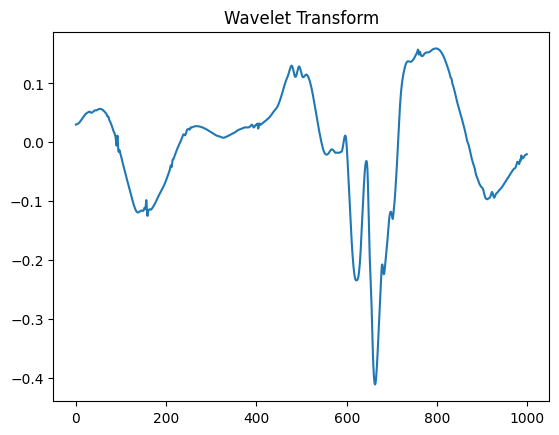

In [ ]:
signal = hasil[0][:1000]
plt.plot(signal)
plt.title('Wavelet Transform')
plt.show()

In [ ]:


"""Normalize Signal using Normalize Bound"""

from wfdb.processing import normalize_bound

normalisasi = []
for i in range(len(hasil)):
    x = normalize_bound(hasil[i], lb=0, ub=1)
    normalisasi.append(x)

"""Signal Segmentation"""

segment_all_signal = []
segment_all_label = []

step = 512

for i in range(len(normalisasi)):

    temp_signal = normalisasi[i]
    pjg_sinyal = len(temp_signal)
    baca = all_label[i]

    for x in range(0, len(temp_signal), step):

        N = (step+x) - pjg_sinyal
        if (x+step < pjg_sinyal):
            ritme = temp_signal[x:x+step]
            segment_all_signal.append(ritme)
            segment_all_label.append(baca)

        elif(N<2600):
            ritme= temp_signal[x:x+step]
            ritme = np.pad(ritme, (0, N), 'constant')
            segment_all_signal.append(ritme)
            segment_all_label.append(baca)

for i in range(len(segment_all_label)):
    all_data.append(segment_all_signal[i])
    all_label.append(segment_all_label[i])

sum(float(num) == 8 for num in all_label) #Check Data for every label






80775

In [ ]:
segment_all_signal2 = np.asarray(segment_all_signal)
segment_all_label2 = np.asarray(segment_all_label)

SAMPLES = 1000
RANDOM_STATE = 42

def upsample_class(signals, labels, class_label, n_samples, random_state):
    class_indices = np.where(labels == class_label)[0]
    class_signals = signals[class_indices]

    if len(class_signals) < n_samples:
      upsampled_signals = resample(class_signals, replace=True, n_samples=n_samples, random_state=random_state)
      upsampled_labels = np.full(n_samples, class_label)

    else:
      upsampled_signals = resample(class_signals, replace=False, n_samples=n_samples, random_state=random_state)
      upsampled_labels = np.full(n_samples, class_label)

    return upsampled_signals, upsampled_labels

upsampled_signals = []
upsampled_labels = []

for class_label in np.unique(segment_all_label2):
    signals, labels = upsample_class(segment_all_signal2, segment_all_label2, class_label, SAMPLES, RANDOM_STATE)
    upsampled_signals.append(signals)
    upsampled_labels.append(labels)

upsampled_signals = np.concatenate(upsampled_signals)
upsampled_labels = np.concatenate(upsampled_labels)


In [ ]:
count_dict = Counter(upsampled_labels)

for value, count in count_dict.items():
    print(f"The value {value} appears {count} times.")

The value 0 appears 1000 times.
The value 1 appears 1000 times.
The value 2 appears 1000 times.
The value 3 appears 1000 times.
The value 4 appears 1000 times.
The value 5 appears 1000 times.
The value 6 appears 1000 times.
The value 7 appears 1000 times.
The value 8 appears 1000 times.
The value 9 appears 1000 times.
The value 10 appears 1000 times.
The value 11 appears 1000 times.
The value 12 appears 1000 times.
The value 13 appears 1000 times.
The value 14 appears 1000 times.


In [ ]:
X = np.expand_dims(upsampled_signals, axis=-1)
Y = to_categorical(upsampled_labels)

#Splitting Dataset
x_train, x_test, y_train, y_test =train_test_split(X, Y, test_size=0.2, shuffle=1)

In [ ]:
y_train.shape

(93216, 15)

In [ ]:
x_train.shape

(93216, 512, 1)

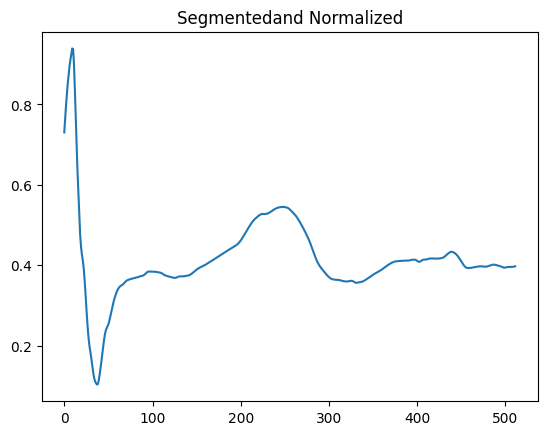

In [ ]:

signal = upsampled_signals[0][:1000]
plt.plot(signal)
plt.title('Segmentedand Normalized')
plt.show()

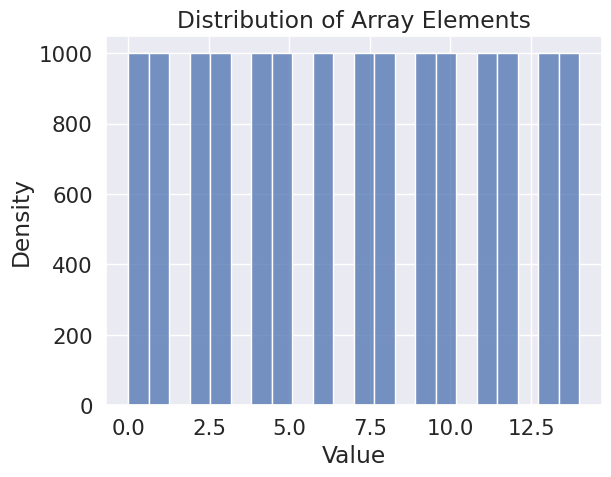

In [ ]:
# Generate an array of random numbers
data = np.random.randn(1000)

# Plot the KDE
sns.histplot(upsampled_labels)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of Array Elements')
plt.show()

## **DNN**

In [ ]:
def model_dnn(x_train):
    model =  tf.keras.Sequential([
                             tf.keras.layers.Dense(32, activation='relu', input_shape=[x_train.shape[1]]),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dense(15, activation='softmax')])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['acc'])

    return model


In [ ]:

model = model_dnn(x_train)


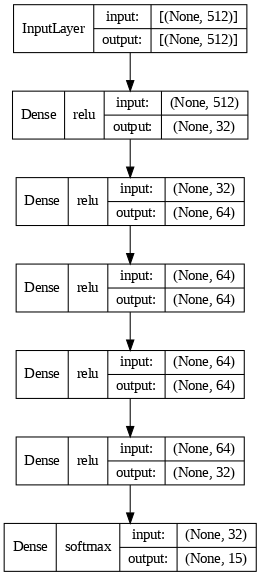

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=1,
    show_dtype=0,
    show_layer_names=0,
    rankdir="TB",
    expand_nested=1,
    dpi=75,
    show_layer_activations=1,
    show_trainable=0,
)

In [ ]:
mc = ModelCheckpoint('best', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
h = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=16,
              epochs=50,
              callbacks=[mc, es])

Epoch 1/50
750/750 [==============================] - 5s 5ms/step - loss: 2.4078 - acc: 0.1923 - val_loss: 2.1037 - val_acc: 0.3047
Epoch 2/50
750/750 [==============================] - 4s 5ms/step - loss: 2.0114 - acc: 0.3174 - val_loss: 2.0240 - val_acc: 0.2537
Epoch 3/50
750/750 [==============================] - 4s 6ms/step - loss: 1.8629 - acc: 0.3568 - val_loss: 1.7586 - val_acc: 0.3787
Epoch 4/50
750/750 [==============================] - 5s 6ms/step - loss: 1.7663 - acc: 0.3783 - val_loss: 1.6806 - val_acc: 0.4130
Epoch 5/50
750/750 [==============================] - 4s 5ms/step - loss: 1.7064 - acc: 0.3963 - val_loss: 1.6696 - val_acc: 0.4637
Epoch 6/50
750/750 [==============================] - 6s 8ms/step - loss: 1.6456 - acc: 0.4236 - val_loss: 1.5519 - val_acc: 0.4303
Epoch 7/50
750/750 [==============================] - 7s 10ms/step - loss: 1.6156 - acc: 0.4353 - val_loss: 1.5026 - val_acc: 0.4707
Epoch 8/50
750/750 [==============================] - 4s 6ms/step - loss: 1

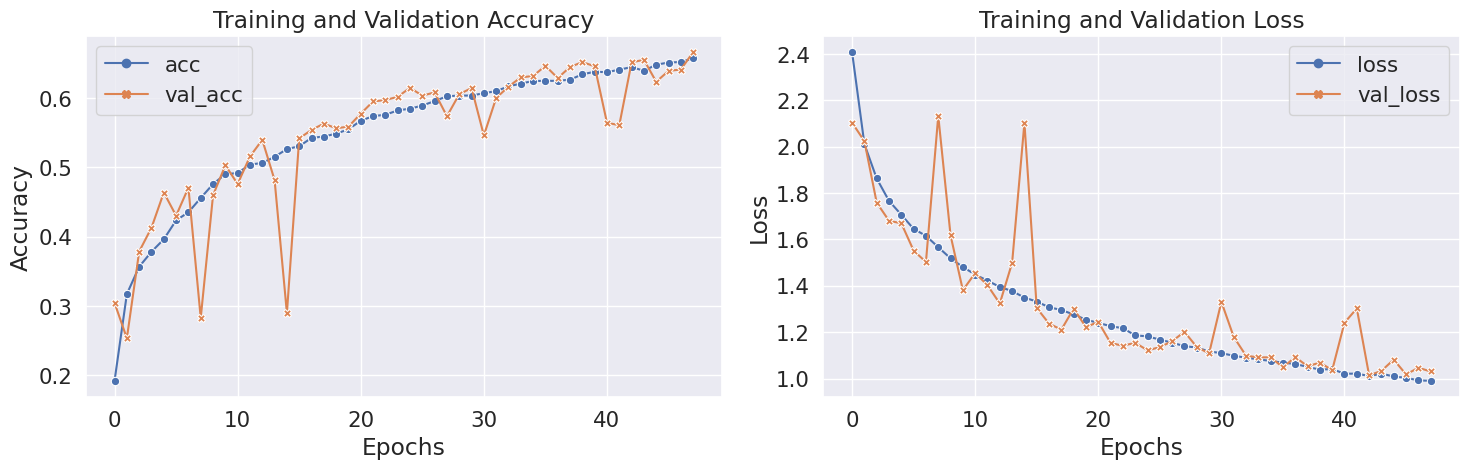

In [ ]:
history_df = pd.DataFrame(h.history)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(ax=axes[0], data=history_df[['acc', 'val_acc']], markers=True, dashes=False)
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')

sns.lineplot(ax=axes[1], data=history_df[['loss', 'val_loss']], markers=True, dashes=False)
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

94/94 [==============================] - 0s 2ms/step


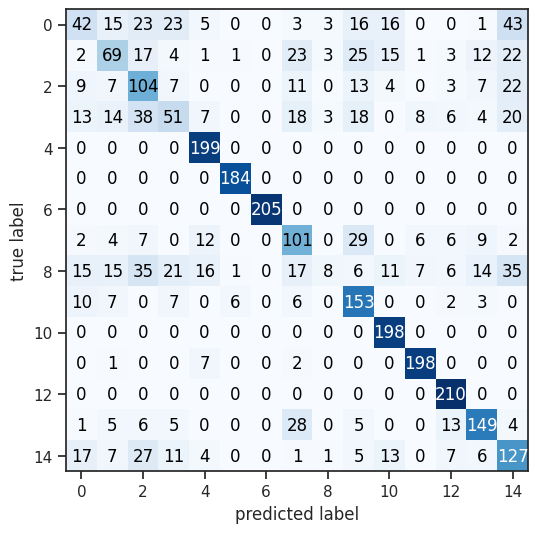

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
fig, ax = plot_confusion_matrix(conf_mat=cm, cmap=plt.cm.Blues, figsize=(6, 6))
plt.show()

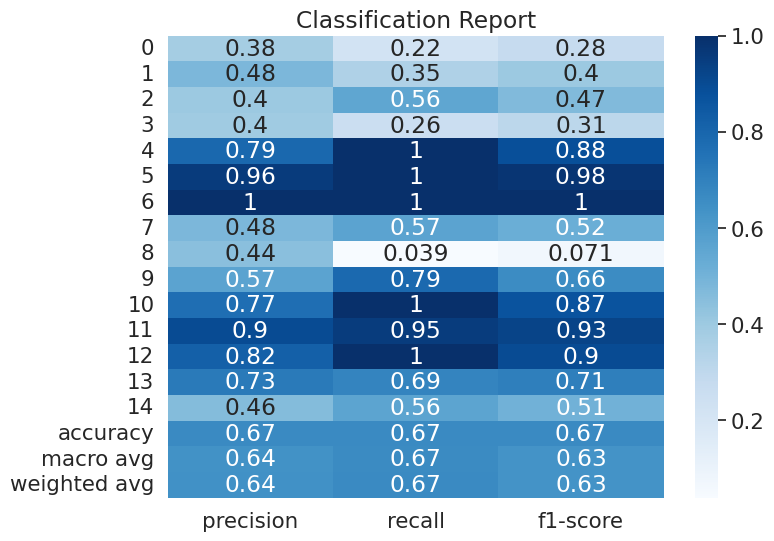

In [ ]:
from sklearn.metrics import classification_report


sns.set(font_scale=1.4)  # Adjust the font scale for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(classification_report(y_true_classes, y_pred_classes, output_dict=True)).iloc[:-1, :].T, annot=True, cmap="Blues")
plt.title('Classification Report')
plt.show()